# Assignement 4
## 1.

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pystan
import random

To begin with I copied the stan example code provided by Jesper. I made slight modifications but nothing major to get it working in my environment.

In [136]:
from __future__ import division
from pylab import * # this line will import math and plot functions that I may need

close('all')

y = array([1,0,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,0,0,0,1]) # coin flips 
 

## Stan implementation
ass4_code = """
data {
    int<lower=0> J; // number of flips, integer with a lower bound = 0  
    int<lower=0,upper=1> y[J]; // coin flips, y is a J length vector of integers
}
parameters {
    real<lower=0,upper=1> theta; // prob of getting a head 
}
transformed parameters {
// no transformed variables to use
}
model {
    theta ~ beta(%f, %f); // prior distribution for theta
    y ~ bernoulli(theta); // likelihood, note that stan will create the posterior automatically. 
}
"""

ass4_dat = {'J': len(y),
               'y': y}

model = pystan.StanModel(model_code=ass4_code %(1,1)) #Create a model instance

fit = model.sampling(data=ass4_dat,iter=10000,warmup=500, chains=1) #Call the sampling using the model instance

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf8dbdac1384f64ca1de3ea435d420e4 NOW.


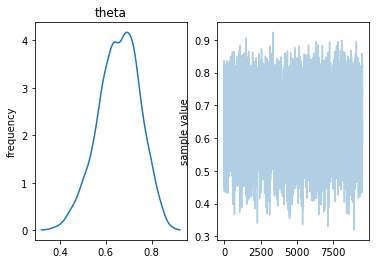

In [137]:
fit.plot()

la = fit.extract(permuted=True)  # return a dictionary of arrays with the sampled parameter data

It seems to be working so now I can start working on the problem of recreating figure 6.4. I will need to find out how to work with the extracted data. I start by plotting the distribution from the sampling above.

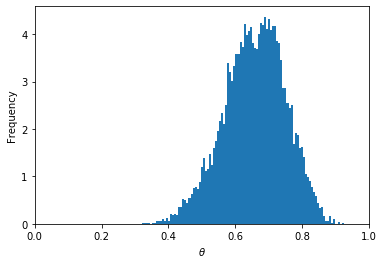

In [138]:
a=la['theta']
    #a=np.matrix(la) #Changing format for ease of indexing
    #k=np.arange(len(a)); a=a[k,0] #Keeping only the parameter data in a
binsize=np.linspace(np.min(a),np.max(a),100)
hist=plt.hist(a,binsize,density=True)
plt.xlim(0,1)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

Since I can call the sampling function using separate prior data dictionaries I create these in a for loop with one index per posterior in the figure I am recreating. In the same loop I can den call the model.sampling function in STAN.

In [139]:
#Data for the likelihood function
N=20 #20 "flips"
z=17 #17 heads
y=list(np.zeros((N-z),dtype=int))+list(np.ones(z,dtype=int))

In [140]:
Data={'J': len(y),'y': y} #Data dictionary for likelihood 
PriorBetas=[(100,100),(18.25,6.75),(1,1)] #tupels with (a, b), parameters for the beta priors
results=[]

Iter=10000 #Number of iteration in Markov Chain
Warmup=500 #Burn in steps in Markov Chain

Theta=np.zeros((3,Iter-Warmup)) #Pre-allocation for the sampled parameter arrays 
for i in range(3):
    model = pystan.StanModel(model_code=ass4_code %PriorBetas[i]) #Creates a model instance with different priors
    results.append(model.sampling(data=Data,iter=Iter,warmup=Warmup, chains=1)) #Extracts the results of the sampling
    Theta[i,:]=results[i].extract(permuted=True)['theta']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19322528e22e912976b22dde461e98b7 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_51053c215f37e05af783781bbdbcc3cd NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf8dbdac1384f64ca1de3ea435d420e4 NOW.


Plotting the results to check that they look reasonable

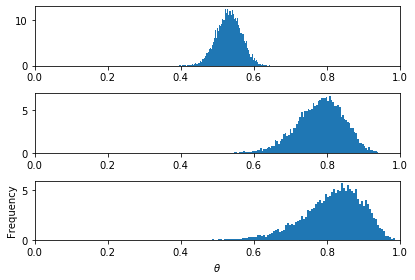

In [141]:
for i in range(3):
    binsize=np.linspace(np.min(Theta[i]),np.max(Theta[i]),100)
    plt.subplot(3,1,i+1)
    hist=plt.hist(Theta[i],binsize,density=True)
    plt.xlim(0,1)

plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')

plt.tight_layout() #Prevents overlapping plots
plt.show()

Something I did not plot in the last assignment was the HDI's. In order to do this I made a function for calculating the HDI's from the MCMC data based on code from chapter 25 in the book. 

In [142]:
def HDIofMCMC(SampleArray, credMass=.95): #Computes the HDI from an array of a unimodal samples of representative values.
    sortedarray=np.sort(SampleArray)
    CielingIndex=np.ceil(credMass*np.size(sortedarray))
    nCI=np.size(sortedarray)-CielingIndex
    ciWidth=np.zeros(int(nCI))
    for i in range(int(nCI)):
        ciWidth[i]=sortedarray[i+int(CielingIndex)]-sortedarray[i]
    HDImin=(sortedarray[np.argmin(ciWidth)])
    HDImax=(sortedarray[np.argmin(ciWidth)+int(CielingIndex)])
    HDIlim=np.array([HDImin,HDImax])
    return(HDIlim)

HDIofMCMC(a)

array([0.47967552, 0.83524005])

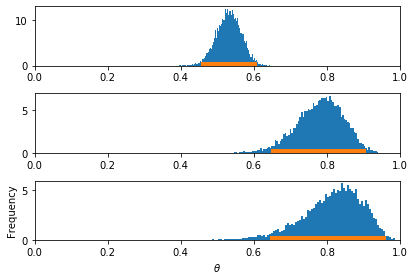

In [143]:
for i in range(3):
    HDIlim=HDIofMCMC(Theta[i])
    binsize=np.linspace(np.min(Theta[i]),np.max(Theta[i]),100)
    plt.subplot(3,1,i+1)
    hist=plt.hist(Theta[i],binsize,density=True)
    plt.plot(HDIlim,(0,0),linewidth=8.0)
    plt.xlim(0,1)

plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')

plt.tight_layout() #Prevents overlapping plots
plt.show()

Now I copy my code from assignment 3 (the analytical sampling) and add the histograms above from the MCMC sampling.

a= [100.    18.25   1.  ]  and b= [100.     6.75   1.  ]


C:\Users\viksan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\viksan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\viksan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\viksan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


<function matplotlib.pyplot.show(*args, **kw)>

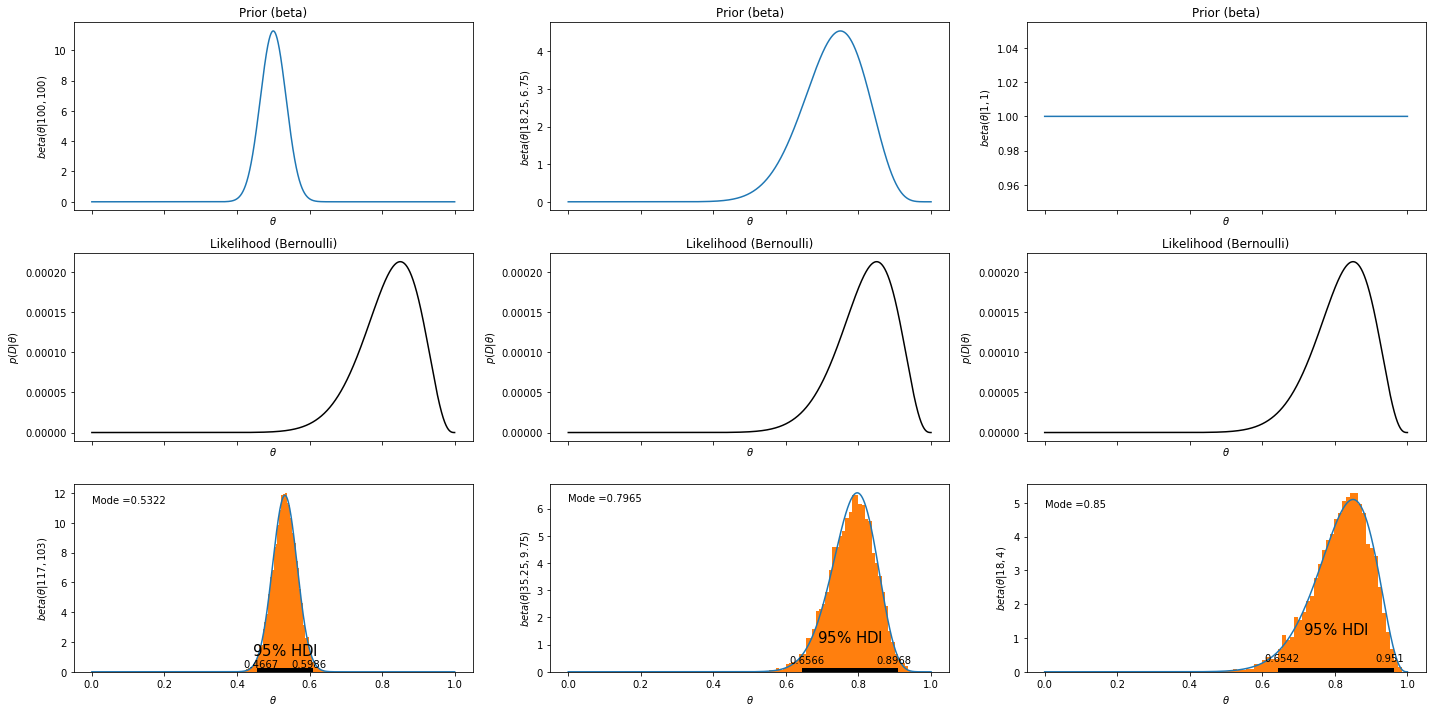

In [147]:
from scipy.special import beta

theta=np.linspace(0,1,10000) #x-array for analytical plotting

def logLF(y,theta): #Log likelihood function
    p=np.log(theta)*y+np.log(1-theta)*(1-y)
    return(p)
def LogIndProduct(y,theta): #Log function for the independent product
    pArray=np.zeros(len(theta))
    for i in range(len(y)):
        pArray+=logLF(y[i],theta)
    return(pArray)
def LogBetaDist(theta,a,b): #log function of the Beta distribution
    p=np.log(theta)*(a-1)+np.log(1-theta)*(b-1)-np.log(beta(a,b))
    return(p)

kappa=[200,25] #concentrations (could be thought of as sample size)
mode=[.5,.75] #desired prior mode for two first graphs
a=np.ones(len(kappa)+1)
b=np.ones(len(kappa)+1)
for i in range(len(kappa)):
    a[i]=mode[i]*(kappa[i]-2)+1
    b[i]=(1-mode[i])*(kappa[i]-2)+1

print('a=',a,' and b=',b)

n=y #Copying the likelihood function from above

Liklhd=np.exp(LogIndProduct(n,theta))

#Data for posterior distributions
aPost=np.ones(3)
bPost=np.ones(3)
for i in range(3):
    aPost[i]=z+a[i]
    bPost[i]=N-z+b[i]

## Plots
fig,axs=plt.subplots(3,3,figsize=(20,10),sharex=True)

#Prior distributions
for i in range(3):
    axs[0,i].plot(theta,np.exp(LogBetaDist(theta,a[i],b[i])))
    axs[0,i].set_title('Prior (beta)')
    axs[0,0].set(xlabel=r'$\theta$',ylabel=r'$beta(\theta|100,100)$')
    axs[0,1].set(xlabel=r'$\theta$',ylabel=r'$beta(\theta|18.25,6.75)$')
    axs[0,2].set(xlabel=r'$\theta$',ylabel=r'$beta(\theta|1,1)$') 

#Likelihood functions
    
    axs[1,i].plot(theta,Liklhd,'k')
    axs[1,i].set_title('Likelihood (Bernoulli)')
    axs[1,i].set(xlabel=r'$\theta$',ylabel=r'$p(D|\theta)$')

#Posterior distributions

    yPost=np.exp(LogBetaDist(theta,aPost[i],bPost[i]))
    axs[2,i].plot(theta,yPost)
#axs[2].set_title('Posterior (beta)') #Varför funkar inte detta?

#Posterior Histograms from MCMC
    binsize=np.linspace(np.min(Theta[i]),np.max(Theta[i]),50)
    axs[2,i].hist(Theta[i],binsize,density=True)
    axs[2,i].set(xlabel=r'$\theta$')
    
#Posterior HDI values
    HDI=HDIofMCMC(Theta[i],.95) #Calculates the 95% HDI of the MCMC data
    
    axs[2,i].plot(HDI,(0,0),'k',linewidth=8.0)
 
    axs[2,i].text(np.mean(HDI), 1.1, r'$95\%$ HDI', fontsize=15,ha='center') #Plots text in the figure
    axs[2,i].text(HDI[0], .3, str(np.round(HDI[0],4)), fontsize=10,ha='center')
    axs[2,i].text(HDI[1], .3, str(np.round(HDI[1],4)), fontsize=10,ha='center')
    axs[2,i].text(0,np.max(yPost),'Mode ='+str(np.round(theta[np.argmax(yPost)],4)),va='top')
    
axs[2,0].set(ylabel=r'$beta(\theta|117,103)$')
axs[2,1].set(ylabel=r'$beta(\theta|35.25,9.75)$')
axs[2,2].set(ylabel=r'$beta(\theta|18,4)$')


plt.tight_layout() #Prevents overlapping plots
plt.show

## 2.
### i.
Now I can start answering the quesitions. I do a new MCMC run using the new prior information y=[1,0,1,1,0,1,1,1,0,1,1,1,1,1] 

In [264]:
y=(1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1 ,1 ,1)
Data={'J': len(y),'y': y} #Data dictionary for likelihood 
PriorBeta=(1,1) #tupel with (a, b), parameters for the uniform beta priors
results=[]

Iter=10000 #Number of iteration in Markov Chain
Warmup=500 #Burn in steps in Markov Chain

ThetaY=np.zeros((3,Iter-Warmup)) #Pre-allocation for the sampled parameter arrays 

model = pystan.StanModel(model_code=ass4_code %PriorBeta) #Creates a model instance with a uniform prior
results=model.sampling(data=Data,iter=Iter,warmup=Warmup, chains=1) #Extracts the results of the sampling
ThetaY=results.extract(permuted=True)['theta'] #Isolates the relevant sample information

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf8dbdac1384f64ca1de3ea435d420e4 NOW.


Plotting the result

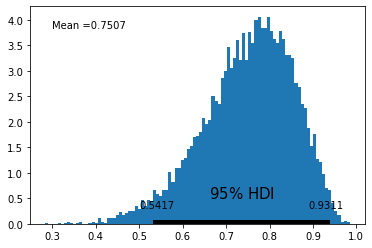

In [271]:
#Posterior Histograms from MCMC
binsizeY=np.linspace(np.min(ThetaY),np.max(ThetaY),100)
plt.hist(ThetaY,binsizeY,density=True)

    
#Posterior HDI values
HDI=HDIofMCMC(ThetaY,.95) #Calculates the 95% HDI of the MCMC data
    
plt.plot(HDI,(0,0),'k',linewidth=8.0)
plt.text(np.mean(HDI), .5, r'$95\%$ HDI', fontsize=15,ha='center') #Plots text in the figure
plt.text(HDI[0], .3, str(np.round(HDI[0],4)), fontsize=10,ha='center')
plt.text(HDI[1], .3, str(np.round(HDI[1],4)), fontsize=10,ha='center')
plt.text(.3,4.0,'Mean ='+str(np.round(np.mean(ThetaY),4)),va='top')

plt.xlabel=r'$\theta$'
plt.show()

The expected value (mean) of the sampled distribution indicates a chance of getting a head to be around 74,9%. The 95% highest density interval of the sampling falls between 54.31-93.42%. This will of course vary slightly if I rerun the sampler. 

### ii.

The probability of $\theta>0.5$ will be higher than 95% since 0.5 is outside of the 95% HDI. I can calculate this value easily using the function I created.

In [266]:
Interval=np.arange(.95,.99,.0001)
k=np.zeros((np.size(Interval),2))
for i in range(np.size(Interval)):
    k[i]=np.abs(HDIofMCMC(Theta,Interval[i])-.5)
print('The probability that Theta > 0.5 is', Interval[np.argmin(k[:,0])])

The probability that Theta > 0.5 is 0.9516999999999998


## b)
Given additional measurements z=[1, 0, 0, 0, 0, 0, 0, 1, 1, 0] I sample a new MCMC chain.

In [267]:
z=(1, 0, 0, 0, 0, 0, 0, 1, 1, 0)
Data={'J': len(z),'y': z} #Data dictionary for likelihood 
PriorBeta=(1,1) #tupel with (a, b), parameters for the uniform beta priors
results=[]

Iter=10000 #Number of iteration in Markov Chain
Warmup=500 #Burn in steps in Markov Chain

ThetaZ=np.zeros((3,Iter-Warmup)) #Pre-allocation for the sampled parameter arrays 

model = pystan.StanModel(model_code=ass4_code %PriorBeta) #Creates a model instance with a uniform prior
results=model.sampling(data=Data,iter=Iter,warmup=Warmup, chains=1) #Extracts the results of the sampling
ThetaZ=results.extract(permuted=True)['theta'] #Isolates the relevant sample information

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf8dbdac1384f64ca1de3ea435d420e4 NOW.


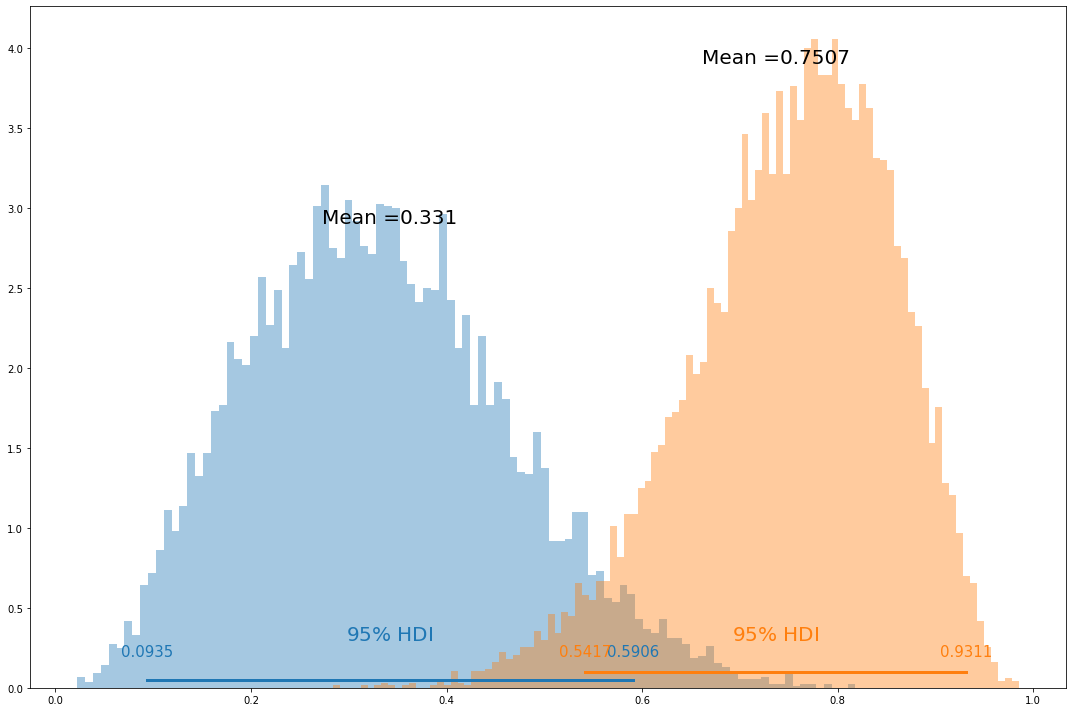

In [312]:

#Posterior Histograms from MCMC
fig= plt.figure(figsize=(15,10))
binsizeZ=np.linspace(np.min(ThetaZ),np.max(ThetaZ),100)
plt.hist(ThetaZ,binsizeZ,density=True,alpha=0.4)
plt.hist(ThetaY,binsizeY,density=True,alpha=0.4)

#Posterior HDI values
HDIZ=HDIofMCMC(ThetaZ,.95) #Calculates the 95% HDI of the MCMC data

plt.plot(HDIZ,(.05,.05),'tab:blue',linewidth=3.0)
plt.text(np.mean(HDIZ), .3, r'$95\%$ HDI', {'color': 'tab:blue'}, fontsize=20,ha='center') #Plots text in the figure
plt.text(HDIZ[0], .2,str(np.round(HDIZ[0],4)),{'color': 'tab:blue'}, fontsize=15,ha='center')
plt.text(HDIZ[1], .2, str(np.round(HDIZ[1],4)),{'color': 'tab:blue'}, fontsize=15,ha='center')
plt.text(np.mean(HDIZ),3.0,'Mean ='+str(np.round(np.mean(ThetaZ),4)), fontsize=20, va='top',ha='center')

plt.plot(HDI,(.1,.1),'tab:orange',linewidth=3.0)
plt.text(np.mean(HDI), .3, r'$95\%$ HDI',{'color': 'tab:orange'}, fontsize=20,ha='center') #Plots text in the figure
plt.text(HDI[0], .2, str(np.round(HDI[0],4)), {'color': 'tab:orange'},fontsize=15,ha='center')
plt.text(HDI[1], .2, str(np.round(HDI[1],4)), {'color': 'tab:orange'},fontsize=15,ha='center')
plt.text(np.mean(HDI),4.0,'Mean ='+str(np.round(np.mean(ThetaY),4)),fontsize=20,va='top',ha='center')

plt.xlabel='Theta'
plt.tight_layout()
plt.show()

Are  and  measurements from the same coin? You may answer this in different ways:
#### 1. 
Answer this by calculating the probability that $\theta_y > \theta_z$ given the measurements $y,z$.
#### 2.
Answer this by creating a new variable $d\theta=\theta_y - \theta_z$  and calculating a 95% credible interval.
#### 3.
Plot a histogram representing $p(d\theta|y,z)$. Is it beta distributed? Motivate your answer.

------------------------------------------------------------------------------------------------------------

Starting with 1. I will calculate where (at what theta value) the HDIs of the two distributions intersect i.e at which. The probability mass to the right of this point should correspond to $p(\theta_y > \theta_z)$

In [341]:
Interval=np.arange(.80,.98,.0001)
kY=np.zeros((np.size(Interval)))
kZ=np.zeros((np.size(Interval)))
kDiff=np.zeros((np.size(Interval)))

for i in range(np.size(Interval)):
    kY[i]=HDIofMCMC(ThetaY,Interval[i])[0]
    kZ[i]=HDIofMCMC(ThetaZ,Interval[i])[1]
    kDiff[i]=abs(kZ[i]-kY[i])
    
ThetaIntersect=kY[np.argmin(kDiff)]
YlargerZ=np.sum(i > ThetaIntersect for i in ThetaY)/np.sum(np.size(ThetaY))

print('p(theta_y>theta_z)=',YlargerZ)

p(theta_y>theta_z)= 0.9502105263157895


I get that $p(\theta_y > \theta_z)=95\%$

#### 2.
Creating a new variable


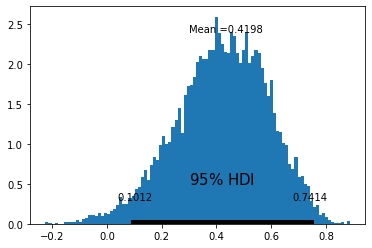

In [354]:
dTheta=ThetaY-ThetaZ

dbinsize=np.linspace(np.min(dTheta),np.max(dTheta),100)
plt.hist(dTheta,dbinsize,density=True)

    
#Posterior HDI values
HDI=HDIofMCMC(dTheta,.95) #Calculates the 95% HDI of the MCMC data
    
plt.plot(HDI,(0,0),'k',linewidth=8.0)
plt.text(np.mean(HDI), .5, r'$95\%$ HDI', fontsize=15,ha='center') #Plots text in the figure
plt.text(HDI[0], .3, str(np.round(HDI[0],4)), fontsize=10,ha='center')
plt.text(HDI[1], .3, str(np.round(HDI[1],4)), fontsize=10,ha='center')
plt.text(.3,2.5,'Mean ='+str(np.round(np.mean(dTheta),4)),va='top')

plt.xlabel=(r'$\theta$')
plt.show()

According to this we can be 95% certainty say that they are from different coins since the 95% HDI does not contain 0. There is also a margin that would indicate that this is not only due to the sampling being noisy

#### 3.
The histogram $d\theta|y,z)$ is the one that is shown above. This cannot be beta distributed since there are values <0. This is not possible since the distribution only is defined for a>0, b>0. In general it can be seen by looking at the analytical for of the beta distribution $dbeta(\theta|a,b)=\frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)}$. Any product or division of two beta distributions would make a new beta distribution (provided a>0, b>0 remain true) but additions or subtractions would not.